<a href="https://colab.research.google.com/github/dfridland/NLP/blob/HW10/NLP_DF_HW10_translation_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [ ]:
!wget http://www.manythings.org/anki/tur-eng.zip

--2023-06-05 21:07:30--  http://www.manythings.org/anki/tur-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5349274 (5.1M) [application/zip]
Saving to: ‘tur-eng.zip’

tur-eng.zip         100%[===================>]   5.10M  1.82MB/s    in 2.8s    

2023-06-05 21:07:33 (1.82 MB/s) - ‘tur-eng.zip’ saved [5349274/5349274]



In [ ]:
!mkdir tur-eng
!unzip tur-eng.zip -d tur-eng/

Archive:  tur-eng.zip
  inflating: tur-eng/tur.txt         
  inflating: tur-eng/_about.txt      


In [ ]:
!ls ./tur-eng/ -lah

ls: -lah: No such file or directory
./tur-eng/:
_about.txt tur.txt


In [ ]:
# Download the file
path_to_file = "./tur-eng/tur.txt"

In [ ]:
def preprocess_sentence(w):
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z0-9ğüşöçİĞÜŞÖÇ?.!,']+", " ", w)
    # I could try matching ^\p{L}+$, which is the shorthand for any letter

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENG, TUR]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [ ]:
en, tr = create_dataset(path_to_file, None)
print(en[0])
print(tr[0])

<start> hi . <end>
<start> merhaba . <end>


In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

In [ ]:
len(en), len(tr)

(141527, 141527)

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
19 ----> ben
401 ----> yapm
70 ----> şt
6 ----> m
3 ----> .
4 ----> tom
86 ----> da
401 ----> yapm
30 ----> ş
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
74 ----> i've
171 ----> done
12 ----> that
32 ----> ,
50 ----> and
94 ----> so
44 ----> has
4 ----> tom
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

Metal device set to: Apple M2 Pro


In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 19]), TensorShape([64, 14]))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 19, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 19, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 11335)


## Define the optimizer and the loss function

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [ ]:
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.0663
Epoch 1 Batch 100 Loss 0.0421
Epoch 1 Batch 200 Loss 0.0647
Epoch 1 Batch 300 Loss 0.0521
Epoch 1 Batch 400 Loss 0.0450
Epoch 1 Batch 500 Loss 0.0753
Epoch 1 Batch 600 Loss 0.0420
Epoch 1 Batch 700 Loss 0.0631
Epoch 1 Batch 800 Loss 0.0491
Epoch 1 Batch 900 Loss 0.0297
Epoch 1 Batch 1000 Loss 0.0693
Epoch 1 Batch 1100 Loss 0.0665
Epoch 1 Batch 1200 Loss 0.0765
Epoch 1 Loss 0.0591
Time taken for 1 epoch 183.9663519859314 sec

Epoch 2 Batch 0 Loss 0.0415
Epoch 2 Batch 100 Loss 0.0409
Epoch 2 Batch 200 Loss 0.0537
Epoch 2 Batch 300 Loss 0.0512
Epoch 2 Batch 400 Loss 0.0355
Epoch 2 Batch 500 Loss 0.0654
Epoch 2 Batch 600 Loss 0.0820
Epoch 2 Batch 700 Loss 0.0726
Epoch 2 Batch 800 Loss 0.0512
Epoch 2 Batch 900 Loss 0.0622
Epoch 2 Batch 1000 Loss 0.0530
Epoch 2 Batch 1100 Loss 0.0577
Epoch 2 Batch 1200 Loss 0.0678
Epoch 2 Loss 0.0568
Time taken for 1 epoch 182.51702308654785 sec

Epoch 3 Batch 0 Loss 0.0449
Epoch 3 Batch 100 Loss 0.0652
Epoch 3 Batch 200 Loss 0.06

Epoch 18 Batch 1000 Loss 0.0534
Epoch 18 Batch 1100 Loss 0.0626
Epoch 18 Batch 1200 Loss 0.0520
Epoch 18 Loss 0.0427
Time taken for 1 epoch 183.53111720085144 sec

Epoch 19 Batch 0 Loss 0.0283
Epoch 19 Batch 100 Loss 0.0354
Epoch 19 Batch 200 Loss 0.0418
Epoch 19 Batch 300 Loss 0.0323
Epoch 19 Batch 400 Loss 0.0375
Epoch 19 Batch 500 Loss 0.0280
Epoch 19 Batch 600 Loss 0.0470
Epoch 19 Batch 700 Loss 0.0642
Epoch 19 Batch 800 Loss 0.0402
Epoch 19 Batch 900 Loss 0.0354
Epoch 19 Batch 1000 Loss 0.0476
Epoch 19 Batch 1100 Loss 0.0513
Epoch 19 Batch 1200 Loss 0.0407
Epoch 19 Loss 0.0416
Time taken for 1 epoch 179.7268888950348 sec

Epoch 20 Batch 0 Loss 0.0434
Epoch 20 Batch 100 Loss 0.0296
Epoch 20 Batch 200 Loss 0.0449
Epoch 20 Batch 300 Loss 0.0393
Epoch 20 Batch 400 Loss 0.0318
Epoch 20 Batch 500 Loss 0.0477
Epoch 20 Batch 600 Loss 0.0300
Epoch 20 Batch 700 Loss 0.0566
Epoch 20 Batch 800 Loss 0.0489
Epoch 20 Batch 900 Loss 0.0384
Epoch 20 Batch 1000 Loss 0.0335
Epoch 20 Batch 1100 Loss 

Epoch 36 Batch 100 Loss 0.0256
Epoch 36 Batch 200 Loss 0.0354
Epoch 36 Batch 300 Loss 0.0348
Epoch 36 Batch 400 Loss 0.0321
Epoch 36 Batch 500 Loss 0.0433
Epoch 36 Batch 600 Loss 0.0275
Epoch 36 Batch 700 Loss 0.0369
Epoch 36 Batch 800 Loss 0.0340
Epoch 36 Batch 900 Loss 0.0460
Epoch 36 Batch 1000 Loss 0.0252
Epoch 36 Batch 1100 Loss 0.0542
Epoch 36 Batch 1200 Loss 0.0745
Epoch 36 Loss 0.0361
Time taken for 1 epoch 180.4172179698944 sec

Epoch 37 Batch 0 Loss 0.0376
Epoch 37 Batch 100 Loss 0.0280
Epoch 37 Batch 200 Loss 0.0186
Epoch 37 Batch 300 Loss 0.0413
Epoch 37 Batch 400 Loss 0.0405
Epoch 37 Batch 500 Loss 0.0421
Epoch 37 Batch 600 Loss 0.0361
Epoch 37 Batch 700 Loss 0.0293
Epoch 37 Batch 800 Loss 0.0218
Epoch 37 Batch 900 Loss 0.0436
Epoch 37 Batch 1000 Loss 0.0503
Epoch 37 Batch 1100 Loss 0.0405
Epoch 37 Batch 1200 Loss 0.0664
Epoch 37 Loss 0.0364
Time taken for 1 epoch 180.01415395736694 sec

Epoch 38 Batch 0 Loss 0.0456
Epoch 38 Batch 100 Loss 0.0120
Epoch 38 Batch 200 Loss 0.

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:

!pip install --upgrade matplotlib

Input: <start> buralar y k l yor benden y k l yor . <end>
Predicted translation: it's about me out of around here . <end> 


/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


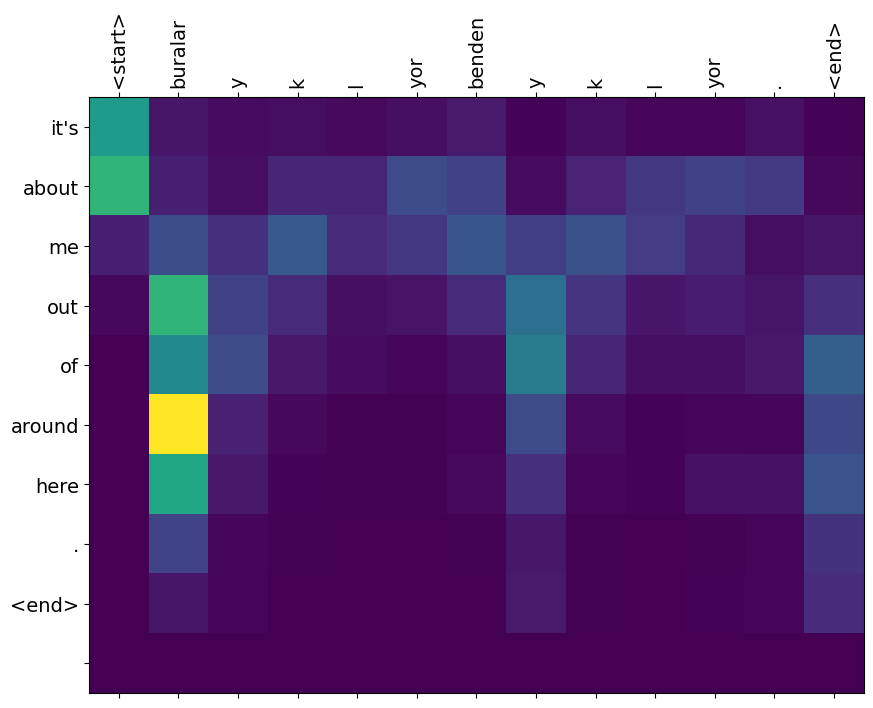

In [ ]:
translate('Buraları yıkılıyor benden yıkılıyor.')

Input: <start> hepimiz arkadaşlar , hayvanlar da ! <end>
Predicted translation: all of us are still animals . <end> 


/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


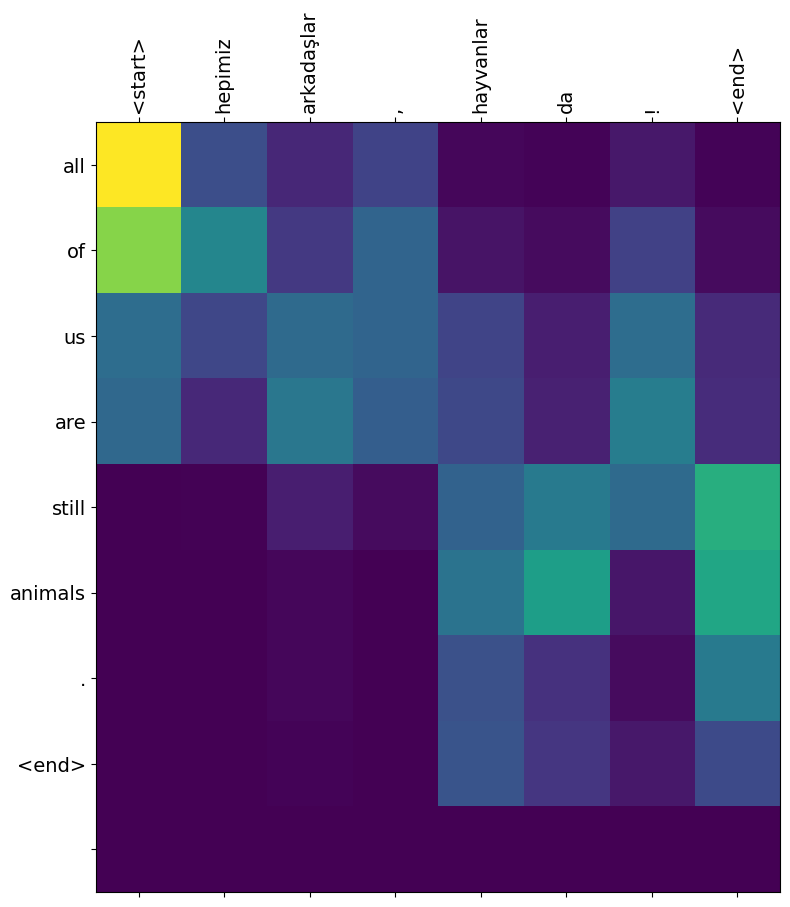

In [ ]:
translate('Hepimiz arkadaşlar, hayvanlar da!')

Input: <start> sana sar çiçek ald m , pazar ndan . <end>
Predicted translation: i bought you a hug , 000 yen . <end> 


/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


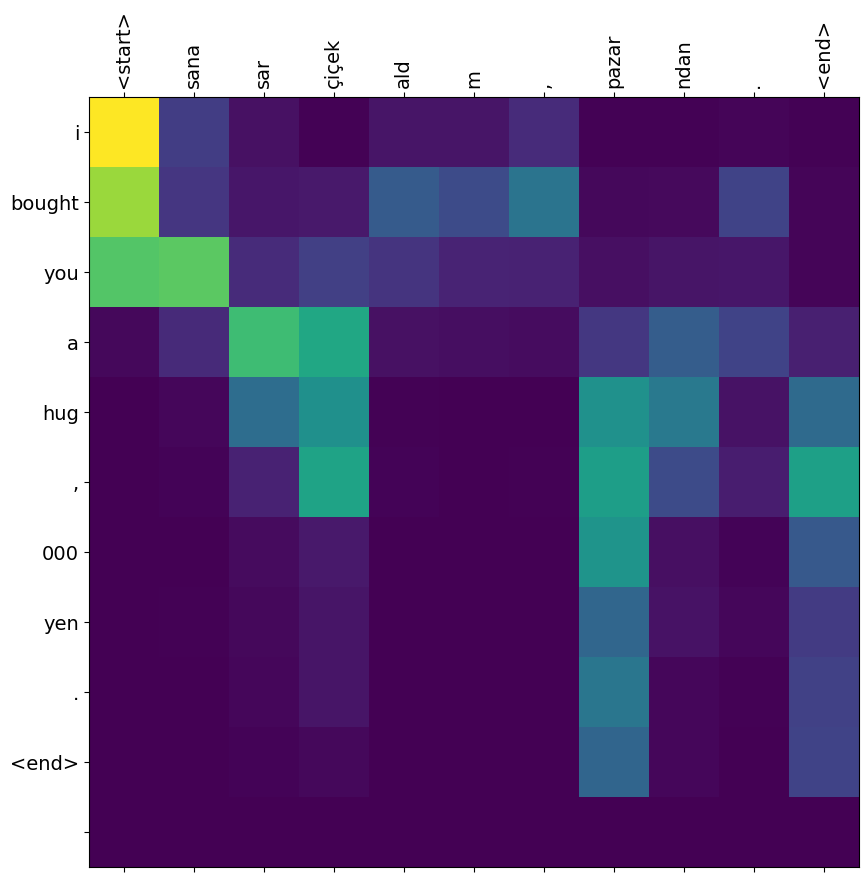

In [ ]:
translate('Sana sarı çiçek aldım, pazarından.')

Input: <start> nas l bir aşk bu karş koyamam <end>
Predicted translation: how come this the love like a baby . <end> 


/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


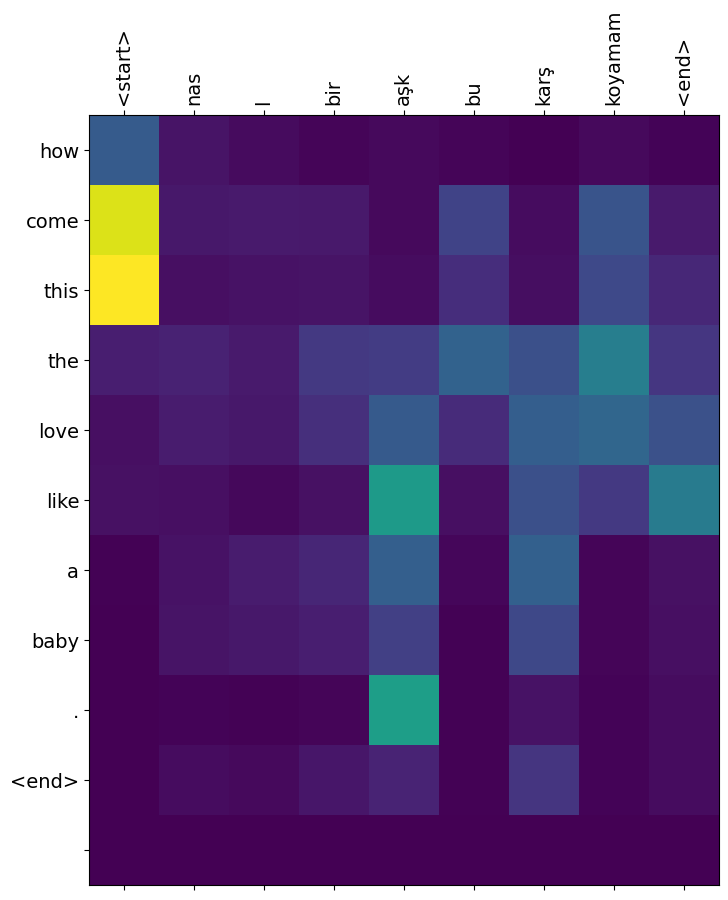

In [ ]:
translate('Nasıl bir aşk bu karşı koyamam')

Input: <start> seni dayanamam k skan r m <end>
Predicted translation: i'd be surprised that noise . <end> 


/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


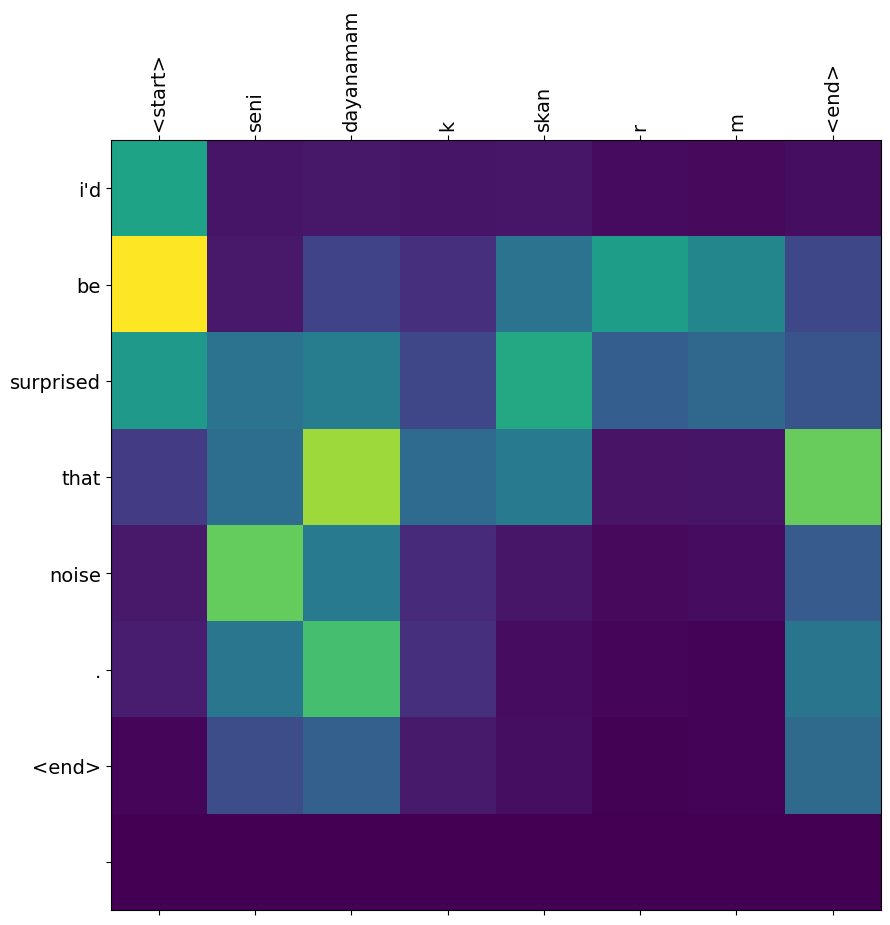

In [ ]:
translate('seni Dayanamam kıskanırım')

Input: <start> sat rlar uçar gider akl mdan <end>
Predicted translation: i need to have any need to have double success . <end> 


/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


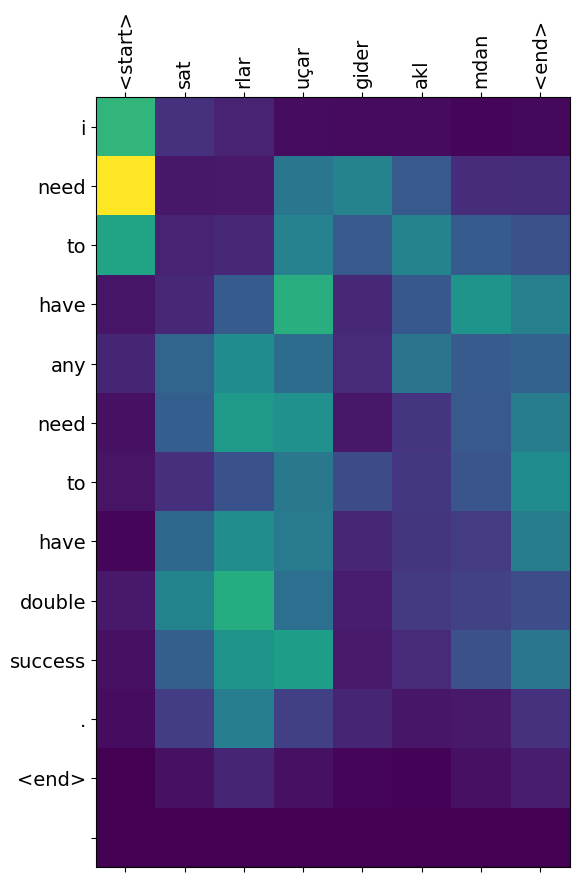

In [ ]:
translate('Satırlar uçar gider aklımdan')

Input: <start> ben evdeyim . <end>
Predicted translation: i'm at home . <end> 


/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


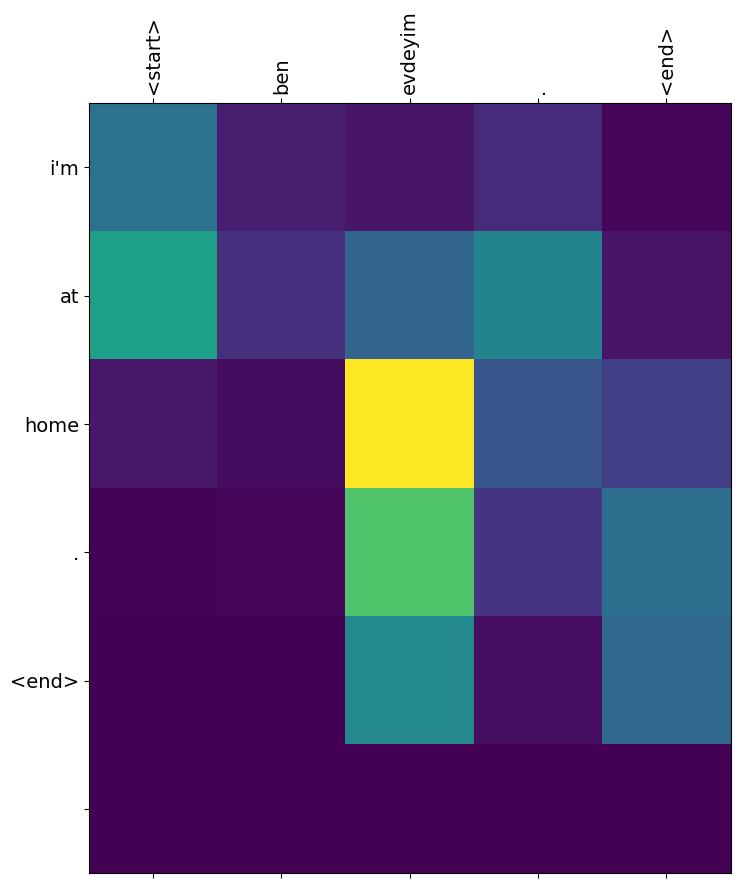

In [ ]:
translate('Ben evdeyim.')

Input: <start> seni seviyorum <end>
Predicted translation: i love you . <end> 


/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


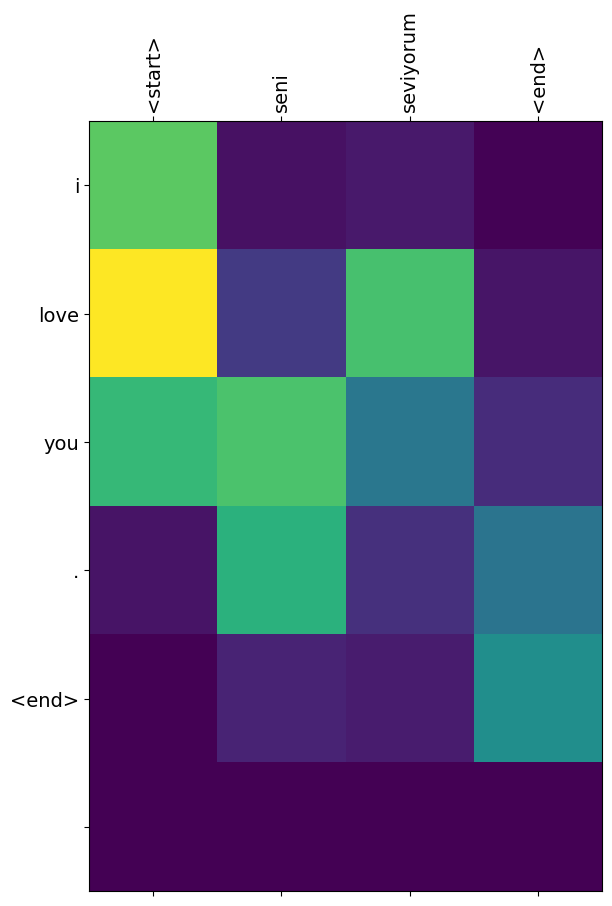

In [ ]:
translate('seni seviyorum')

Input: <start> senden nefret ediyorum <end>
Predicted translation: i hate you . <end> 


/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


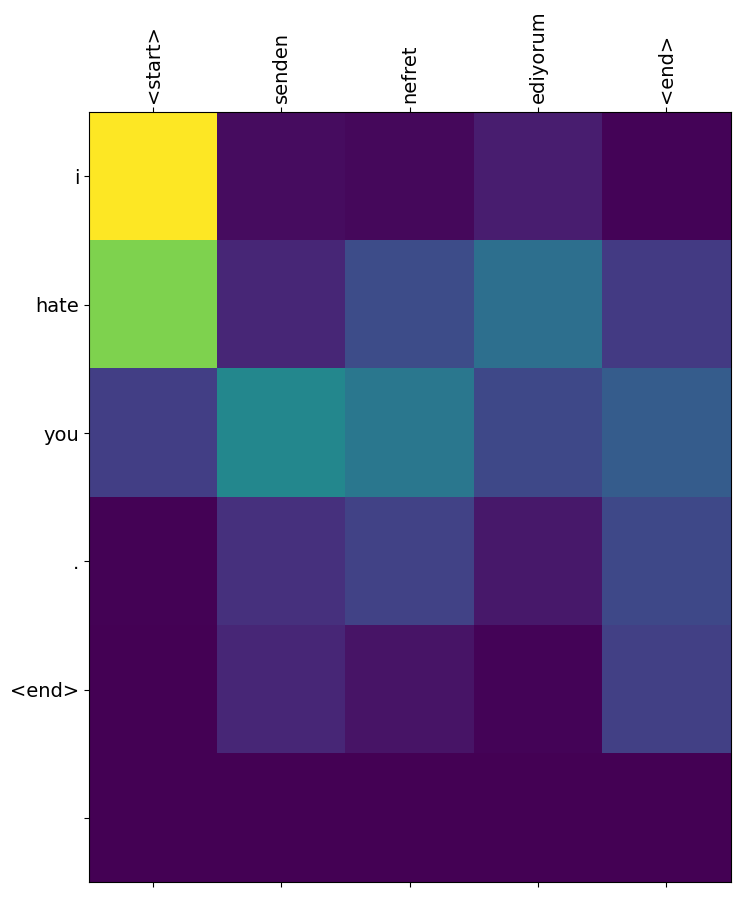

In [ ]:
translate('senden nefret ediyorum')

Input: <start> ben eve geliyorum <end>
Predicted translation: i'm coming home . <end> 


/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/var/folders/g_/9v3q8zfn4dj84j48wgjpsd7c0000gn/T/ipykernel_95270/282331986.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


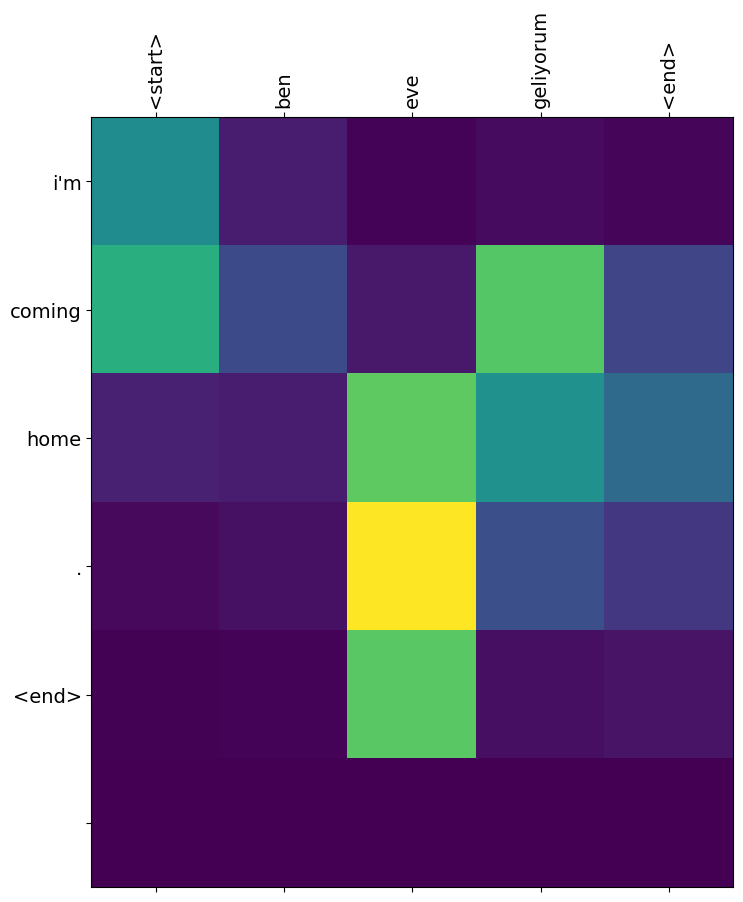

In [ ]:
translate("ben eve geliyorum")